In [109]:
from fastai.vision.all import *
from PIL import ImageOps

In [110]:
path = Path()/'datasets/bears/teddys'
teddys = (path).ls().sorted()

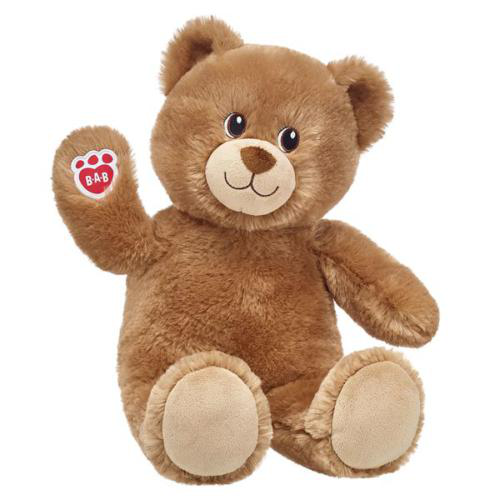

In [111]:
img = Image.open(teddys[1])
img

In [112]:
array(img)[200:202, 200: 202]

array([[[208, 162, 128],
        [197, 151, 117]],

       [[174, 128,  94],
        [181, 135, 101]]], dtype=uint8)

In [113]:
tensor(img)[200:202, 200:202]

tensor([[[208, 162, 128],
         [197, 151, 117]],

        [[174, 128,  94],
         [181, 135, 101]]], dtype=torch.uint8)

In [114]:
img_o = Image.open(teddys[1])
img = ImageOps.grayscale(img_o)
img_t = tensor(img)
img_t.shape

torch.Size([500, 500])

In [115]:
df = pd.DataFrame(img_t[200:210, 200: 210])
df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9
0,172,161,155,150,135,117,115,126,153,137
1,138,145,145,132,116,114,128,142,142,133
2,113,129,134,122,118,131,145,148,121,114
3,110,118,124,129,142,154,150,136,122,110
4,114,114,121,138,153,156,146,137,138,125
5,120,123,132,142,146,145,148,155,130,125
6,125,134,138,134,134,143,150,151,120,122
7,125,134,130,118,126,146,143,124,133,135
8,135,115,102,104,110,114,127,143,137,136
9,103,92,93,108,113,108,114,128,139,149


In [128]:
full_teddys = [tensor(ImageOps.grayscale(Image.open(i).resize((50, 50)))) for i in (path).ls()]
full_tomato = [tensor(ImageOps.grayscale(Image.open(i).resize((50, 50)))) for i in (Path.cwd()/'datasets/Tomato_leaf/Healthy').ls()]

In [129]:
print(full_teddys[1].shape, type(full_teddys))
print(full_tomato[1].shape)

torch.Size([50, 50]) <class 'list'>
torch.Size([50, 50])


In [131]:
stacked_teddys = torch.stack(full_teddys).float()/255
stacked_tomato = torch.stack(full_tomato).float()/255

In [133]:
stacked_teddys.shape, stacked_tomato.shape

(torch.Size([172, 50, 50]), torch.Size([1591, 50, 50]))

In [134]:
len(stacked_teddys.shape), len(stacked_tomato.shape)

(3, 3)

In [135]:
stacked_teddys.dim(), stacked_tomato.dim()

(3, 3)

In [136]:
stacked_teddys.mean(), stacked_tomato.mean()

(tensor(0.7202), tensor(0.4557))

<AxesSubplot:>

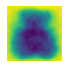

In [138]:
mean_teddy = stacked_teddys.mean(0)
show_image(mean_teddyeddy)

<AxesSubplot:>

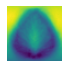

In [140]:
mean_tomato = stacked_tomato.mean(0)
show_image(mean_tomato)

In [141]:
import matplotlib.pyplot as plt

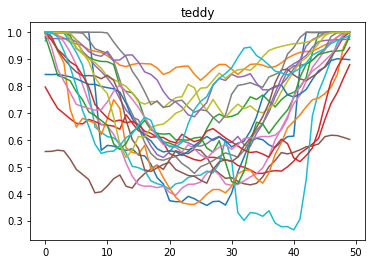

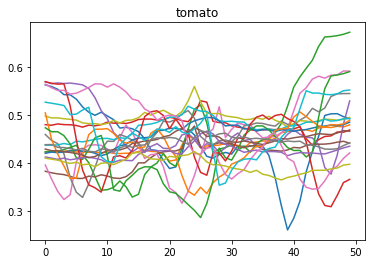

In [142]:
for i in range(0, 20):
    plt.plot(stacked_teddys[i].mean(0))
plt.title('teddy')
plt.show()

for i in range(0, 20):
    plt.plot(stacked_tomato[i].mean(0))
plt.title('tomato')
plt.show()

In [149]:
def bear_distance(x, mean): return (x-mean).abs().mean((-1, -2))

In [151]:
bear_distance(stacked_teddys[1], mean_teddy)

tensor(0.1890)

In [155]:
def is_bear(x): return bear_distance(x, mean_teddy) < bear_distance(x, mean_tomato)

In [160]:
is_bear(stacked_teddys[1]), is_bear(stacked_teddys[1]).float()

(tensor(True), tensor(1.))

In [162]:
accuracy_teddy = is_bear(stacked_teddys[1]).float().mean()
accuracy_tomato = 1 - is_bear(stacked_tomato[1]).float().mean()

accuracy_teddy, accuracy_tomato

(tensor(1.), tensor(1.))